# 1. load data and basic process

In [1]:
import pandas as pd 
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow import keras 
from keras.preprocessing.text import Tokenizer
import string
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.preprocessing import sequence
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
from google.colab import files
uploaded=files.upload()

Saving Womens Clothing E-Commerce Reviews.csv to Womens Clothing E-Commerce Reviews.csv


In [3]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [4]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
df.drop_duplicates(subset =('Clothing ID', 'Age', 'Title', 'Review'),
                     keep = False, inplace = True)

In [6]:
df.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23339.000000,23339.000000,23339.000000,23339.000000,23339.000000,23339.000000
mean,11745.680792,917.977977,43.224560,4.193496,0.821586,2.551909
std,6779.016548,203.759156,12.293843,1.111146,0.382869,5.716568
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5879.500000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11744.000000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17617.500000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


# 2. Visualizations

(1) General correlation

No obvious connection between variables, apart from recommended ind and rating

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 6 Text major ticklabel objects>)

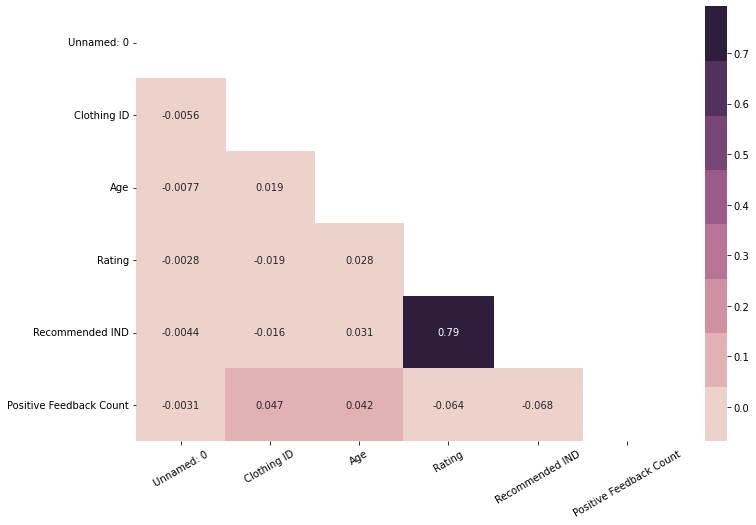

In [9]:
plt.figure(figsize=(12, 8))

# Getting the Upper Triangle of the co-relation matrix
import numpy as np

matrix = np.triu(df.corr())

# using the upper triangle matrix as mask 
sns.heatmap(df.corr(), annot=True, cmap = sns.cubehelix_palette(8), mask=matrix)

plt.xticks(rotation=30)

(2) Age

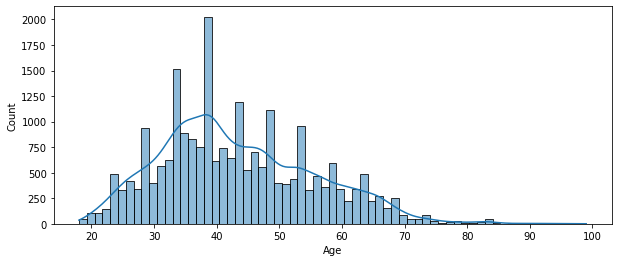

In [10]:
plt.figure(figsize = (10, 4))
sns.histplot(data=df, x='Age', kde=True)

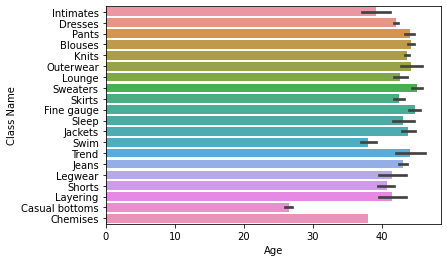

In [11]:
sns.barplot(x=df['Age'], y=df['Class Name'])

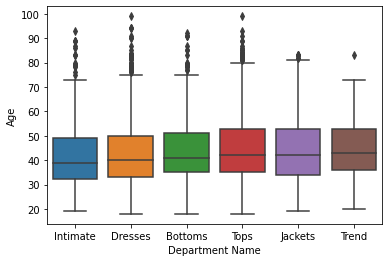

In [12]:
sns.boxplot(x=df['Department Name'], y=df['Age'])
plt.show()

(3）Ratings with other features

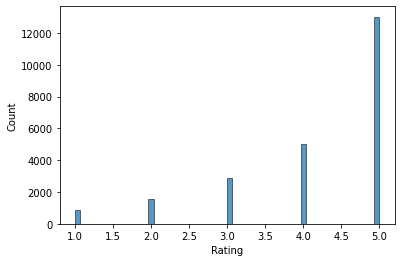

In [13]:
sns.histplot(data=df, x='Rating', kde=False)

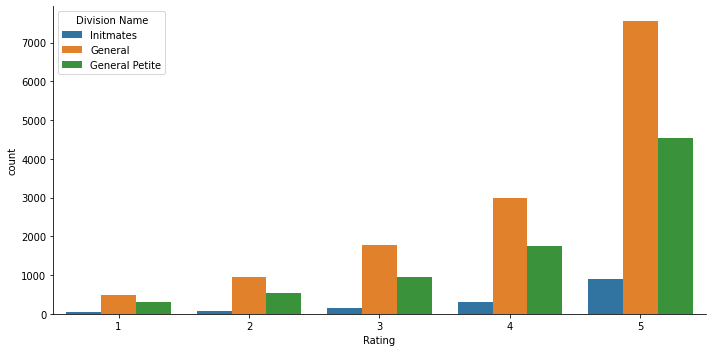

In [14]:
sns.catplot(data = df, x ="Rating", hue = "Division Name", kind='count', height=5, aspect=2, legend_out=False)

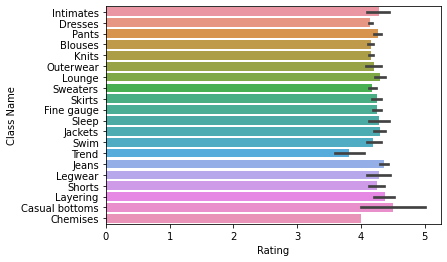

In [15]:
sns.barplot(x=df['Rating'], y=df['Class Name'])

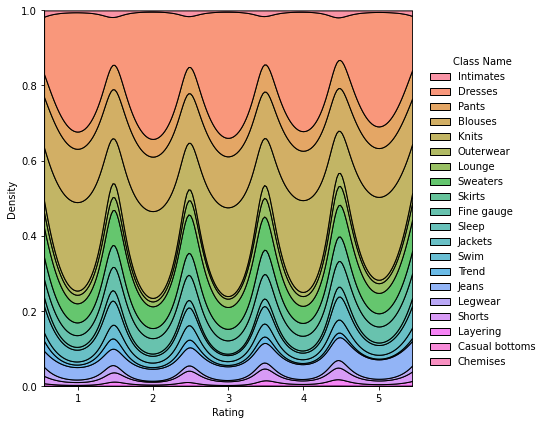

In [16]:
#ditribution of positive ratings
sns.displot(data=df,
           x='Rating', hue="Class Name",
    kind="kde", height=6,
    multiple="fill", clip=(0, None)
)

(4) Division, Department and Class Name 

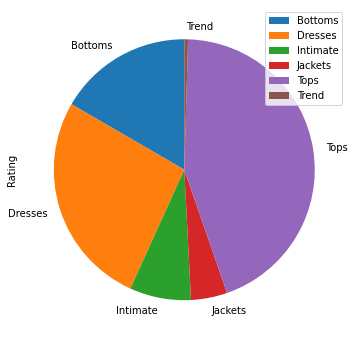

In [17]:
df.groupby(['Department Name']).sum().plot(kind='pie', subplots=False, shadow = False,startangle=90,figsize=(8,6), y='Rating')

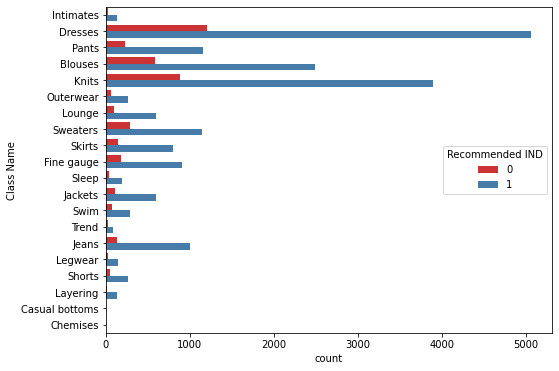

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y='Class Name', hue='Recommended IND', palette = "Set1")

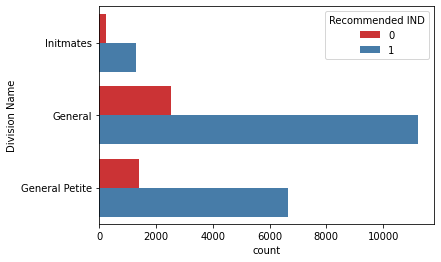

In [19]:
sns.countplot(data=df, y='Division Name', hue='Recommended IND', palette = "Set1")

# 3. Cleaning the data

## Select subcolumns

In [20]:
new_df = df[['Title','Review','Rating','Recommended IND']]

In [21]:
new_df = new_df.dropna()

In [22]:
new_df.columns = ["Title", "Text", "Rating", "Sentiment"]

In [23]:
new_df

,Title,Text,Rating,Sentiment
2,Some major design flaws,I had such high hopes for this dress and reall...,3,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1
4,Flattering shirt,This shirt is very flattering to all due to th...,5,1
5,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0
6,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1
...,...,...,...,...
23481,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1
23482,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1
23483,"Cute, but see through","This fit well, but the top was very see throug...",3,0
23484,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1


In [24]:
new_df['Sentiment'].value_counts()

1    16100
0     3575
Name: Sentiment, dtype: int64

Let's have a look at some 5s:

In [25]:
new_df[new_df.Rating == 5].head(10)

,Title,Text,Rating,Sentiment
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1
4,Flattering shirt,This shirt is very flattering to all due to th...,5,1
6,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1
8,Flattering,I love this dress. i usually get an xs but it ...,5,1
9,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1
12,Perfect!!!,More and more i find myself reliant on the rev...,5,1
13,Runs big,Bought the black xs to go under the larkspur m...,5,1
17,Looks great with white pants,Took a chance on this blouse and so glad i did...,5,1
18,Super cute and cozy,"A flattering, super cozy coat. will work well...",5,1
19,Stylish and comfortable,I love the look and feel of this tulle dress. ...,5,1


And some 1s as well:

In [26]:
new_df[new_df.Rating == 1].head(10)

,Title,Text,Rating,Sentiment
61,Itchy tags,"3 tags sewn in, 2 small (about 1'' long) and 1...",1,0
97,Huge,I was very excited to order this top in red xs...,1,0
110,Poor quality,This is so thin and poor quality. especially f...,1,0
161,"Scratchy, uncomfortable top",The title says it all....this fabric of this t...,1,0
214,Not as pictured!,The skirt that i received had very little blue...,1,0
241,"Loved this, then washed it twice and it fell a...",I loved this dress from the moment i tried it ...,1,0
334,Not a good fit,This top was way too short (i'm only 5'1) and ...,1,0
356,Could have been cute...,The fabric was nothing special (i usually like...,1,0
389,Bad quality.,"I don't normally review my purchases, but i wa...",1,0
603,"Wanted to love, but sadly will return.","These run very small!! they are also short, al...",1,0


## Stopwords

In [27]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [28]:
"not" in stop and "no" in stop

True

There are too many 'not' words, hence we decide not to use stopwords here since we are supposed to predict the sentiment.

## Tokenization

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
def tokenize(column):
    # Tokenize a Pandas dataframe columns and returns a list of tokens.
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] #delete digits

In [31]:
new_df['Tokenized'] = new_df.apply(lambda x: tokenize(x['Text']), axis=1)
new_df[['Text', 'Tokenized']].head()

,Text,Tokenized
2,I had such high hopes for this dress and reall...,"[I, had, such, high, hopes, for, this, dress, ..."
3,"I love, love, love this jumpsuit. it's fun, fl...","[I, love, love, love, this, jumpsuit, it, fun,..."
4,This shirt is very flattering to all due to th...,"[This, shirt, is, very, flattering, to, all, d..."
5,"I love tracy reese dresses, but this one is no...","[I, love, tracy, reese, dresses, but, this, on..."
6,I aded this in my basket at hte last mintue to...,"[I, aded, this, in, my, basket, at, hte, last,..."


##  Stemming and Punctuations Removal

In [32]:
from nltk.stem import SnowballStemmer # Stemmers remove morphological affixes from words, leaving only the word stem.
snow = SnowballStemmer('english') 

import re

In [33]:
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # lower case
    sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
    tokens = sentence.split()
    out = []
    for t in tokens:
        out.append(snow.stem(t))
    out = " ".join(out)
    out = re.sub(r'[\'|"|#]', r'', out) # remove these punctuation
    return out    

In [34]:
new_df["Text_clean"] = new_df["Tokenized"].apply(cleanup)

In [35]:
new_df["Text_clean"]

2        [i had such high hope for this dress and reall...
3        [i love love love this jumpsuit it fun flirti ...
4        [this shirt is veri flatter to all due to the ...
5        [i love traci rees dress but this one is not f...
6        [i ade this in my basket at hte last mintu to ...
                               ...                        
23481    [i was veri happi to snag this dress at such a...
23482    [it remind me of matern cloth soft stretchi sh...
23483    [this fit well but the top was veri see throug...
23484    [i bought this dress for a wed i have this sum...
23485    [this dress in a love platinum is feminin and ...
Name: Text_clean, Length: 19675, dtype: object

## Wordclouds

In [36]:
# can only work in google colab
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS

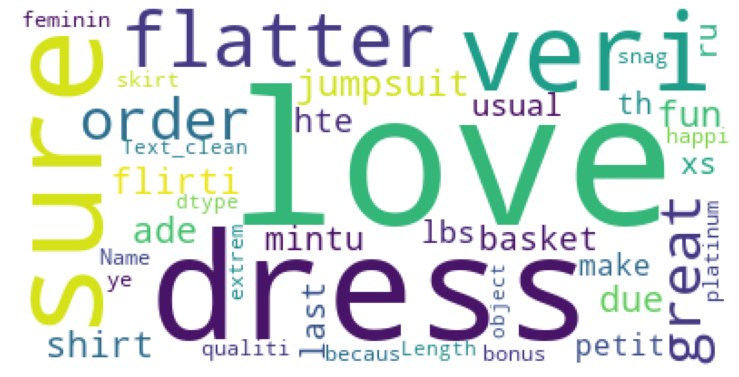

In [38]:
wordcloud = WordCloud(background_color="white", max_words =250).generate(str(new_df.Text_clean.loc[new_df.Rating == 5]))

plt.figure(figsize = (13, 13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 4. model

## train test split 

In [40]:
from sklearn.model_selection import train_test_split
# spliting the data into trainng and testing data:- 
X_train, X_test, y_train, y_test = train_test_split(new_df['Text_clean'],
                                                   new_df['Sentiment'], test_size=0.3,random_state=0)

## Ways to convert text to vector 

### 1) Bi-gram BOW

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
bi_gram = CountVectorizer(ngram_range=(1,2), min_df = 5, binary = True) # 1 means the minimum is unigram, 2 means max is bigrams, 

bi_gram_vectors_train = bi_gram.fit_transform(X_train)
bi_gram_vectors_test = bi_gram.transform(X_test)

In [46]:
bi_gram_vectors_train.shape

(13772, 22942)

In [47]:
pd.DataFrame(bi_gram_vectors_train.toarray(), columns = bi_gram.get_feature_names())

,abdomen,abil,abil to,abl,abl to,about,about abov,about an,about and,about ani,...,zipper it,zipper on,zipper or,zipper that,zipper up,zipper was,zipper would,zone,zoom,zoom in
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2) tf-idf

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 5)

tfidf_vectors_train = tfidf.fit_transform(X_train)
tfidf_vectors_test = tfidf.transform(X_test)

In [49]:
tfidf_vectors_train.shape

(13772, 22942)

In [50]:
pd.DataFrame(tfidf_vectors_train.toarray(), columns = tfidf.get_feature_names())

,abdomen,abil,abil to,abl,abl to,about,about abov,about an,about and,about ani,...,zipper it,zipper on,zipper or,zipper that,zipper up,zipper was,zipper would,zone,zoom,zoom in
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare measurements

In [51]:
from sklearn.metrics import confusion_matrix,classification_report, f1_score, recall_score, accuracy_score, precision_score, plot_confusion_matrix

In [52]:
def eval(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print("Test_Set")
    print(classification_report(y_test, y_pred))
    print("Train_Set")
    print(classification_report(y_train, y_pred_train))
    fig, ax = plt.subplots(figsize=(8, 8))
    
    plot_confusion_matrix(model, X_test, y_test, ax=ax)

## Applying Logistic Regression

1）bi-gram

In [53]:
pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
from sklearn.linear_model import LogisticRegression

log_bi_gram = LogisticRegression(C =0.6, max_iter=1000, class_weight= "balanced", random_state=101)
log_bi_gram.fit(bi_gram_vectors_train,y_train)

LogisticRegression(C=0.6, class_weight='balanced', max_iter=1000,
                   random_state=101)

Test_Set
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1082
           1       0.94      0.92      0.93      4821

    accuracy                           0.89      5903
   macro avg       0.81      0.82      0.82      5903
weighted avg       0.89      0.89      0.89      5903

Train_Set
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2493
           1       1.00      0.99      1.00     11279

    accuracy                           1.00     13772
   macro avg       0.99      1.00      0.99     13772
weighted avg       1.00      1.00      1.00     13772



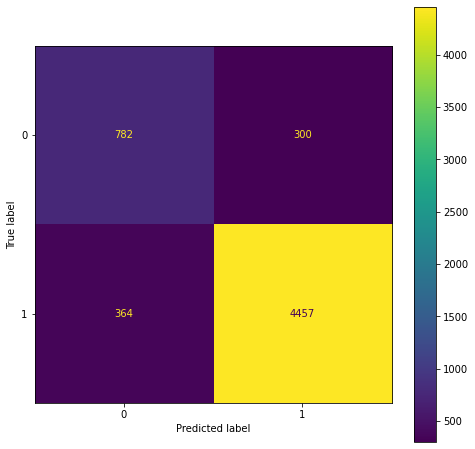

In [55]:
eval(log_bi_gram, bi_gram_vectors_train, bi_gram_vectors_test)

In [56]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    scores = cross_val_score(log_bi_gram, bi_gram_vectors_train, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        log_count_rec_bi = scores
    elif i == "f1-1":
        log_count_f1_bi = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8926077177094565

 precision-0          score for count : 0.6901816599555333

 recall-0             score for count : 0.7404578313253013

 f1-0                 score for count : 0.7140600941102495

 precision-1          score for count : 0.9417075133839337

 recall-1             score for count : 0.9262340551391693

 f1-1                 score for count : 0.9338777999640795



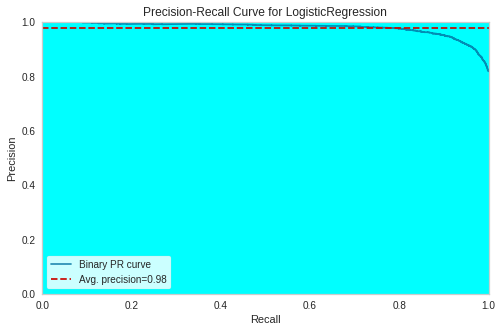

In [57]:
from yellowbrick.classifier import PrecisionRecallCurve
viz = PrecisionRecallCurve(
#                             LogisticRegression(C=0.1, max_iter=1000, random_state=101, class_weight="balanced"),
                            log_bi_gram,
                            classes=log_bi_gram.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('cyan')

viz.fit(bi_gram_vectors_train,y_train)
viz.score(bi_gram_vectors_test, y_test)
viz.show();

In [58]:
log_AP_bi = viz.score_

2）tf-idf

In [59]:
tfidf_vectors_train = tfidf.fit_transform(X_train)
tfidf_vectors_test = tfidf.transform(X_test)

In [60]:
log_tf_gram = LogisticRegression(C =0.6, max_iter=1000, class_weight= "balanced", random_state=101)
log_tf_gram.fit(tfidf_vectors_train,y_train)

LogisticRegression(C=0.6, class_weight='balanced', max_iter=1000,
                   random_state=101)

Test_Set
              precision    recall  f1-score   support

           0       0.63      0.85      0.72      1082
           1       0.96      0.89      0.92      4821

    accuracy                           0.88      5903
   macro avg       0.79      0.87      0.82      5903
weighted avg       0.90      0.88      0.89      5903

Train_Set
              precision    recall  f1-score   support

           0       0.69      0.96      0.81      2493
           1       0.99      0.91      0.95     11279

    accuracy                           0.92     13772
   macro avg       0.84      0.93      0.88     13772
weighted avg       0.94      0.92      0.92     13772



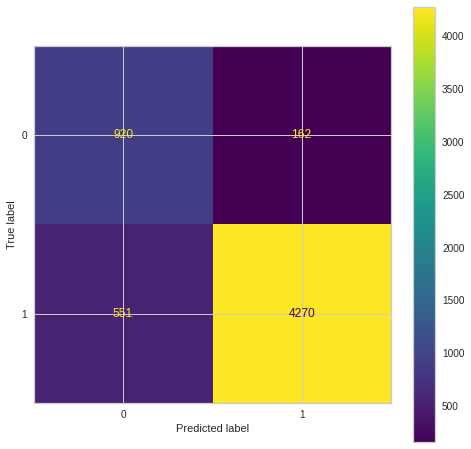

In [61]:
eval(log_tf_gram, tfidf_vectors_train, tfidf_vectors_test)

In [62]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    scores = cross_val_score(log_tf_gram, tfidf_vectors_train, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        log_count_rec_tfidf = scores
    elif i == "f1-1":
        log_count_f1_tfidf = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8811355537215692

 precision-0          score for count : 0.6265649357903591

 recall-0             score for count : 0.851574297188755

 f1-0                 score for count : 0.7218081407693774

 precision-1          score for count : 0.9643771647043387

 recall-1             score for count : 0.8876666855456335

 f1-1                 score for count : 0.9244138155175718



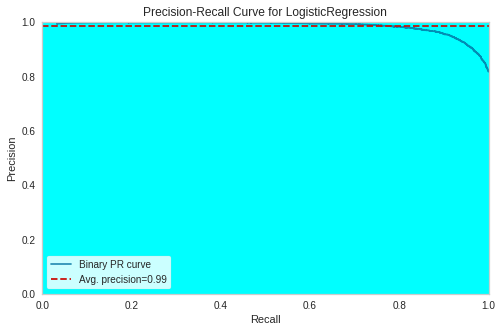

In [63]:
viz = PrecisionRecallCurve(
#                             LogisticRegression(C=0.1, max_iter=1000, random_state=101, class_weight="balanced"),
                            log_tf_gram,
                            classes=log_tf_gram.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('cyan')

viz.fit(tfidf_vectors_train,y_train)
viz.score(tfidf_vectors_test, y_test)
viz.show();

In [64]:
log_AP_tfidf = viz.score_

## Applying Naive Bayes

1) bi-gram

In [65]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

In [66]:
nb = MultinomialNB()

Test_Set
              precision    recall  f1-score   support

           0       0.65      0.83      0.73      1082
           1       0.96      0.90      0.93      4821

    accuracy                           0.89      5903
   macro avg       0.81      0.87      0.83      5903
weighted avg       0.90      0.89      0.89      5903

Train_Set
              precision    recall  f1-score   support

           0       0.71      0.95      0.81      2493
           1       0.99      0.91      0.95     11279

    accuracy                           0.92     13772
   macro avg       0.85      0.93      0.88     13772
weighted avg       0.94      0.92      0.93     13772



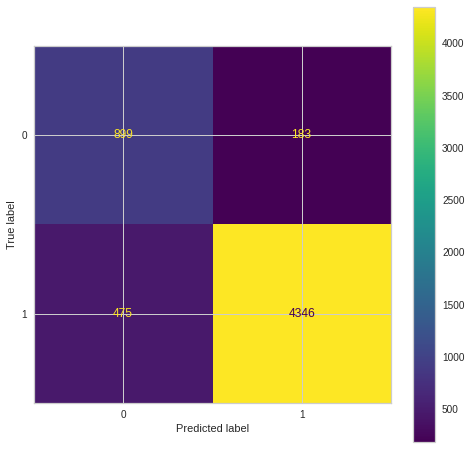

In [67]:
nb.fit(bi_gram_vectors_train, y_train)
eval(nb, bi_gram_vectors_train, bi_gram_vectors_test)

In [68]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = MultinomialNB()
    scores = cross_val_score(model, bi_gram_vectors_train, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        nb_count_rec_bi = scores
    elif i == "f1-1":
        nb_count_f1_bi = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8861454983541555

 precision-0          score for count : 0.6405212336116985

 recall-0             score for count : 0.8475662650602409

 f1-0                 score for count : 0.7295380514051867

 precision-1          score for count : 0.9637037219236667

 recall-1             score for count : 0.8946700743202

 f1-1                 score for count : 0.9278905517966198



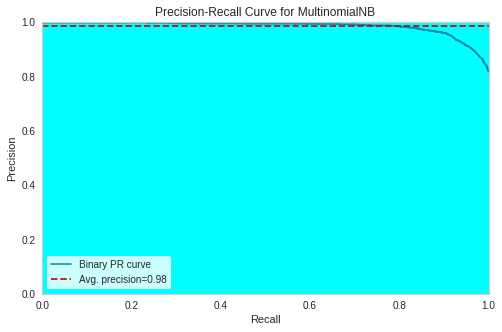

In [69]:
viz = PrecisionRecallCurve(
                            MultinomialNB(),
                            classes=nb.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('cyan')

viz.fit(bi_gram_vectors_train,y_train)
viz.score(bi_gram_vectors_test, y_test)
viz.show();

In [70]:
nb_AP_bi = viz.score_

2) tf-idf

Test_Set
              precision    recall  f1-score   support

           0       0.93      0.08      0.15      1082
           1       0.83      1.00      0.91      4821

    accuracy                           0.83      5903
   macro avg       0.88      0.54      0.53      5903
weighted avg       0.85      0.83      0.77      5903

Train_Set
              precision    recall  f1-score   support

           0       0.97      0.18      0.31      2493
           1       0.85      1.00      0.92     11279

    accuracy                           0.85     13772
   macro avg       0.91      0.59      0.61     13772
weighted avg       0.87      0.85      0.81     13772



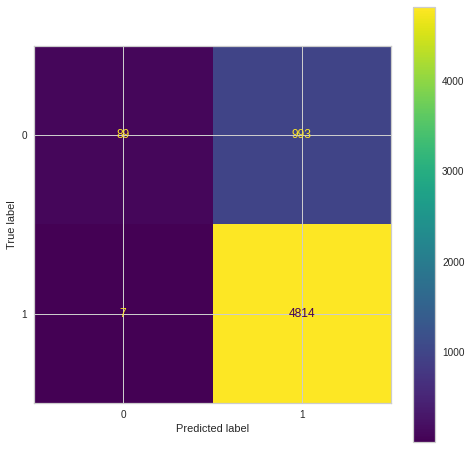

In [71]:
nb.fit(tfidf_vectors_train, y_train)
eval(nb, tfidf_vectors_train, tfidf_vectors_test)

In [72]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = MultinomialNB()
    scores = cross_val_score(model, tfidf_vectors_train, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        nb_count_rec_tfidf = scores
    elif i == "f1-1":
        nb_count_f1_tfidf = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8311070953135327

 precision-0          score for count : 0.943524720893142

 recall-0             score for count : 0.07181847389558234

 f1-0                 score for count : 0.13315414667409944

 precision-1          score for count : 0.8296200548112038

 recall-1             score for count : 0.9989359342256792

 f1-1                 score for count : 0.9064371921294343



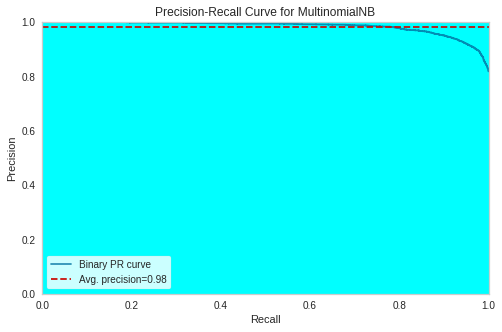

In [73]:
viz = PrecisionRecallCurve(
                            MultinomialNB(),
                            classes=nb.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('cyan')

viz.fit(tfidf_vectors_train,y_train)
viz.score(tfidf_vectors_test, y_test)
viz.show();

In [74]:
nb_AP_tfidf = viz.score_

## Applying SVM 

1） bi-gram

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
# fit the countVectorizer to the training data:-
vect = CountVectorizer().fit(X_train)

In [76]:
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<13772x8445 sparse matrix of type '<class 'numpy.int64'>'
	with 579813 stored elements in Compressed Sparse Row format>

In [77]:
from sklearn import svm
clf = svm.SVC(kernel='linear')

In [78]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=0.01, class_weight="balanced", random_state=101)
svc.fit(uni_gram_vectors_train,y_train)

LinearSVC(C=0.01, class_weight='balanced', random_state=101)

In [79]:
# train the classifier: 
clf.fit(bi_gram_vectors_train, y_train)

SVC(kernel='linear')

In [80]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
# predict the transformed test documents: =
predictions = clf.predict(bi_gram.transform(X_test))
print(classification_report(y_test, predictions))
print('Accuracy score: ', round(accuracy_score(y_test, predictions),2))
print('F1_score: ', round(f1_score(y_test, predictions),2))

              precision    recall  f1-score   support

           0       0.68      0.63      0.66      1082
           1       0.92      0.93      0.93      4821

    accuracy                           0.88      5903
   macro avg       0.80      0.78      0.79      5903
weighted avg       0.88      0.88      0.88      5903

Accuracy score:  0.88
F1_score:  0.93


In [81]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=0.01, class_weight="balanced", random_state=101)
svc.fit(bi_gram_vectors_train,y_train)

LinearSVC(C=0.01, class_weight='balanced', random_state=101)

Test_Set
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      1082
           1       0.95      0.92      0.93      4821

    accuracy                           0.89      5903
   macro avg       0.81      0.85      0.83      5903
weighted avg       0.90      0.89      0.89      5903

Train_Set
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2493
           1       1.00      0.96      0.98     11279

    accuracy                           0.97     13772
   macro avg       0.93      0.98      0.95     13772
weighted avg       0.97      0.97      0.97     13772



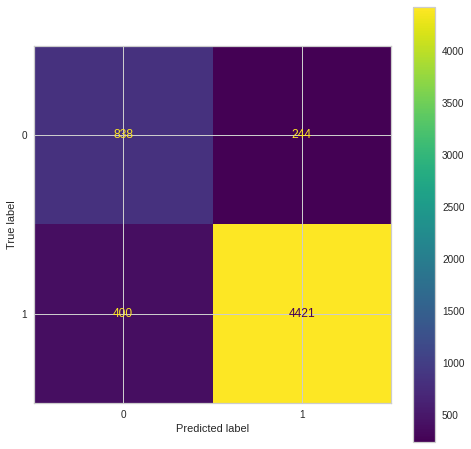

In [82]:
eval(svc, bi_gram_vectors_train, bi_gram_vectors_test)

In [83]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = LinearSVC(C=0.01, class_weight="balanced", random_state=101)
    scores = cross_val_score(model, bi_gram_vectors_train, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        svc_count_rec_bi = scores
    elif i == "f1-1":
        svc_count_f1_bi = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8915183403899645

 precision-0          score for count : 0.6704083146528556

 recall-0             score for count : 0.7909927710843373

 f1-0                 score for count : 0.7254416252426731

 precision-1          score for count : 0.9518924845436324

 recall-1             score for count : 0.9137329538660979

 f1-1                 score for count : 0.9323953912858238



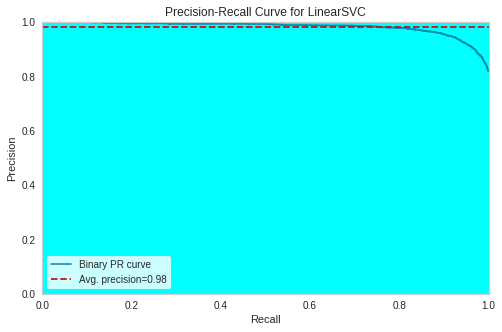

In [84]:
viz = PrecisionRecallCurve(
                            LinearSVC(C=0.01, class_weight="balanced", random_state=101),
                            classes=svc.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('cyan')

viz.fit(bi_gram_vectors_train,y_train)
viz.score(bi_gram_vectors_test, y_test)
viz.show();

In [85]:
svc_AP_bi = viz.score_

2) tfidf

In [86]:
# train the classifier: 
clf.fit(tfidf_vectors_train, y_train)

SVC(kernel='linear')

In [87]:
# predict the transformed test documents: =
predictions = clf.predict(tfidf.transform(X_test))
print(classification_report(y_test, predictions))
print('Accuracy score: ', round(accuracy_score(y_test, predictions),2))
print('F1_score: ', round(f1_score(y_test, predictions),2))

              precision    recall  f1-score   support

           0       0.77      0.63      0.69      1082
           1       0.92      0.96      0.94      4821

    accuracy                           0.90      5903
   macro avg       0.85      0.79      0.82      5903
weighted avg       0.89      0.90      0.89      5903

Accuracy score:  0.9
F1_score:  0.94


In [88]:
X_train_vectorized = vect.transform(X_train)
model = svm.SVC(kernel='linear')
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
print('accuracy :', accuracy_score(y_test, predictions))

accuracy : 0.8683720142300525


In [89]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=0.01, class_weight="balanced", random_state=101)
svc.fit(tfidf_vectors_train,y_train)

LinearSVC(C=0.01, class_weight='balanced', random_state=101)

Test_Set
              precision    recall  f1-score   support

           0       0.57      0.84      0.68      1082
           1       0.96      0.86      0.90      4821

    accuracy                           0.85      5903
   macro avg       0.76      0.85      0.79      5903
weighted avg       0.89      0.85      0.86      5903

Train_Set
              precision    recall  f1-score   support

           0       0.59      0.90      0.71      2493
           1       0.98      0.86      0.91     11279

    accuracy                           0.87     13772
   macro avg       0.78      0.88      0.81     13772
weighted avg       0.90      0.87      0.88     13772



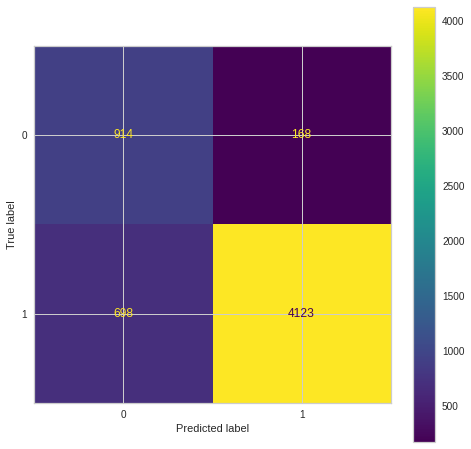

In [90]:
eval(svc, tfidf_vectors_train, tfidf_vectors_test)

In [91]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = LinearSVC(C=0.01, class_weight="balanced", random_state=101)
    scores = cross_val_score(model, tfidf_vectors_train, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        svc_count_rec_tfidf = scores
    elif i == "f1-1":
        svc_count_f1_tfidf = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8512928549369543

 precision-0          score for count : 0.5583663344759715

 recall-0             score for count : 0.8556032128514056

 f1-0                 score for count : 0.6756926478101095

 precision-1          score for count : 0.9638275967786445

 recall-1             score for count : 0.8503405293662331

 f1-1                 score for count : 0.9035238166726612



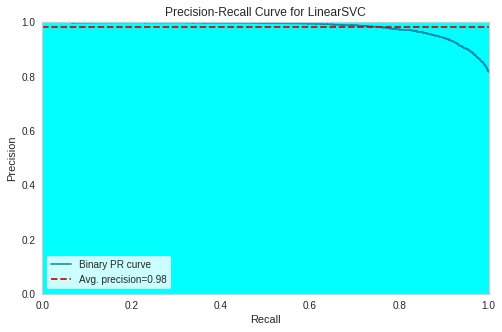

In [92]:
viz = PrecisionRecallCurve(
                            LinearSVC(C=0.01, class_weight="balanced", random_state=101),
                            classes=svc.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('cyan')

viz.fit(tfidf_vectors_train,y_train)
viz.score(tfidf_vectors_test, y_test)
viz.show();

In [93]:
svc_AP_tfidf = viz.score_

## Applying Random Forest 

1） bi-gram

In [94]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(200, max_depth = 12, random_state = 42, n_jobs = -1, class_weight="balanced")

In [95]:
# train the classifier: 
rf.fit(bi_gram_vectors_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=200,
                       n_jobs=-1, random_state=42)

Test_Set
              precision    recall  f1-score   support

           0       0.60      0.76      0.67      1082
           1       0.94      0.89      0.91      4821

    accuracy                           0.86      5903
   macro avg       0.77      0.82      0.79      5903
weighted avg       0.88      0.86      0.87      5903

Train_Set
              precision    recall  f1-score   support

           0       0.70      0.88      0.78      2493
           1       0.97      0.92      0.94     11279

    accuracy                           0.91     13772
   macro avg       0.84      0.90      0.86     13772
weighted avg       0.92      0.91      0.91     13772



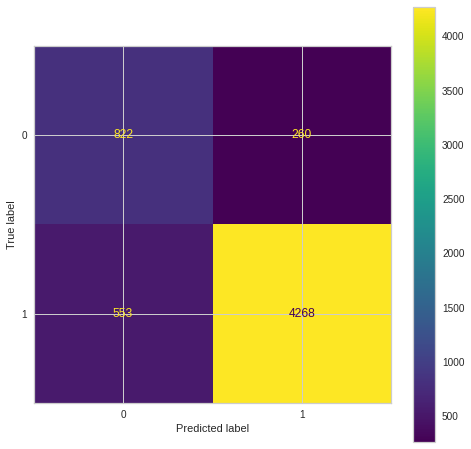

In [96]:
eval(rf, bi_gram_vectors_train, bi_gram_vectors_test)

In [97]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = RandomForestClassifier(200, max_depth = 12, random_state = 42, n_jobs = -1, class_weight="balanced")
    scores = cross_val_score(model, bi_gram_vectors_train, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        rf_count_rec_bi = scores
    elif i == "f1-1":
        rf_count_f1_bi = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8632009595753584

 precision-0          score for count : 0.5968812218441134

 recall-0             score for count : 0.7545108433734941

 f1-0                 score for count : 0.6663854155785314

 precision-1          score for count : 0.9423744922552052

 recall-1             score for count : 0.8872235804590106

 f1-1                 score for count : 0.9139532424317579



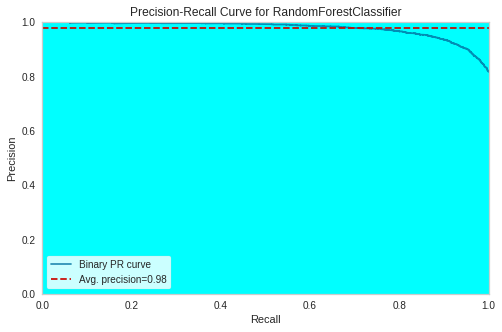

In [98]:
viz = PrecisionRecallCurve(
                            RandomForestClassifier(200, max_depth = 12, random_state = 42, n_jobs = -1, class_weight="balanced"),
                            classes=rf.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('cyan')

viz.fit(bi_gram_vectors_train,y_train)
viz.score(bi_gram_vectors_test, y_test)
viz.show();

In [99]:
rf_AP_bi = viz.score_

2) tfidf

In [100]:
# train the classifier: 
rf.fit(tfidf_vectors_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=200,
                       n_jobs=-1, random_state=42)

Test_Set
              precision    recall  f1-score   support

           0       0.60      0.73      0.66      1082
           1       0.94      0.89      0.91      4821

    accuracy                           0.86      5903
   macro avg       0.77      0.81      0.78      5903
weighted avg       0.87      0.86      0.87      5903

Train_Set
              precision    recall  f1-score   support

           0       0.71      0.90      0.79      2493
           1       0.98      0.92      0.95     11279

    accuracy                           0.92     13772
   macro avg       0.84      0.91      0.87     13772
weighted avg       0.93      0.92      0.92     13772



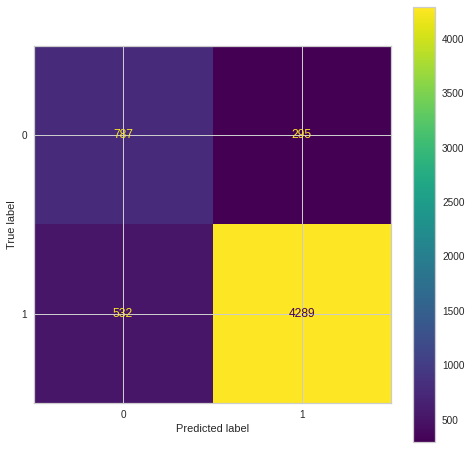

In [101]:
eval(rf, tfidf_vectors_train, tfidf_vectors_test)

In [102]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = RandomForestClassifier(200, max_depth = 12, random_state = 42, n_jobs = -1, class_weight="balanced")
    scores = cross_val_score(model, tfidf_vectors_train, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        rf_count_rec_tfidf = scores
    elif i == "f1-1":
        rf_count_f1_tfidf = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8631272839189968

 precision-0          score for count : 0.5998727381576725

 recall-0             score for count : 0.7336321285140563

 f1-0                 score for count : 0.6599186257821288

 precision-1          score for count : 0.9380874918489697

 recall-1             score for count : 0.8917454863536534

 f1-1                 score for count : 0.9143154950669332



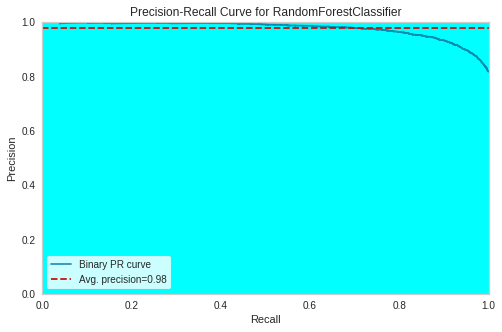

In [103]:
viz = PrecisionRecallCurve(
                            RandomForestClassifier(200, max_depth = 12, random_state = 42, n_jobs = -1, class_weight="balanced"),
                            classes=rf.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('cyan')

viz.fit(tfidf_vectors_train,y_train)
viz.score(tfidf_vectors_test, y_test)
viz.show();

In [104]:
rf_AP_tfidf = viz.score_

## Applying Ada Boosting 

1） bi-gram

In [105]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)

In [106]:
# train the classifier: 
ada.fit(bi_gram_vectors_train, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

Test_Set
              precision    recall  f1-score   support

           0       0.69      0.58      0.63      1082
           1       0.91      0.94      0.93      4821

    accuracy                           0.88      5903
   macro avg       0.80      0.76      0.78      5903
weighted avg       0.87      0.88      0.87      5903

Train_Set
              precision    recall  f1-score   support

           0       0.87      0.75      0.81      2493
           1       0.95      0.98      0.96     11279

    accuracy                           0.94     13772
   macro avg       0.91      0.86      0.88     13772
weighted avg       0.93      0.94      0.93     13772



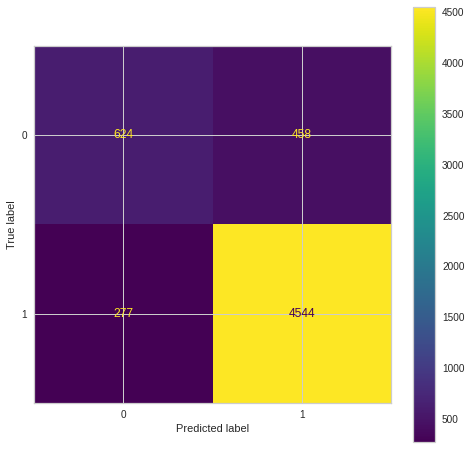

In [107]:
eval(ada, bi_gram_vectors_train, bi_gram_vectors_test)

In [108]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = AdaBoostClassifier(n_estimators= 500, random_state = 42)    
    scores = cross_val_score(model, bi_gram_vectors_train, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        ada_count_rec_bi = scores
    elif i == "f1-1":
        ada_count_f1_bi = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8790295788261011

 precision-0          score for count : 0.7001454875847631

 recall-0             score for count : 0.5816321285140562

 f1-0                 score for count : 0.6349560575109664

 precision-1          score for count : 0.910880215219404

 recall-1             score for count : 0.9447643118301899

 f1-1                 score for count : 0.9274927096180277



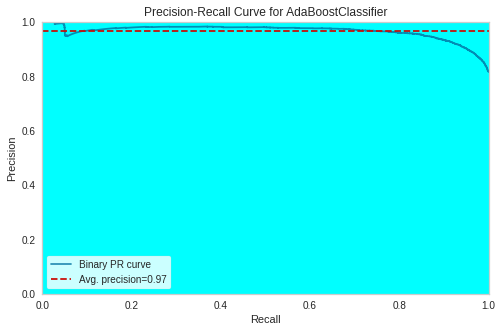

In [109]:
viz = PrecisionRecallCurve(
                            AdaBoostClassifier(n_estimators= 500, random_state = 42),
                            classes=ada.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('cyan')

viz.fit(bi_gram_vectors_train,y_train)
viz.score(bi_gram_vectors_test, y_test)
viz.show();

In [110]:
ada_AP_bi = viz.score_

2) tfidf

In [111]:
# train the classifier: 
ada.fit(tfidf_vectors_train, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

Test_Set
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      1082
           1       0.91      0.94      0.93      4821

    accuracy                           0.88      5903
   macro avg       0.80      0.77      0.78      5903
weighted avg       0.87      0.88      0.87      5903

Train_Set
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      2493
           1       0.96      0.98      0.97     11279

    accuracy                           0.95     13772
   macro avg       0.93      0.90      0.91     13772
weighted avg       0.95      0.95      0.95     13772



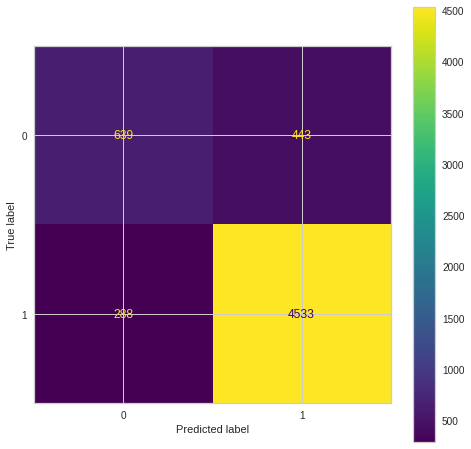

In [112]:
eval(ada, tfidf_vectors_train, tfidf_vectors_test)

In [113]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = AdaBoostClassifier(n_estimators= 500, random_state = 42)    
    scores = cross_val_score(model, tfidf_vectors_train, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        ada_count_rec_tfidf = scores
    elif i == "f1-1":
        ada_count_f1_tfidf = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8774326405291999

 precision-0          score for count : 0.6927451696834075

 recall-0             score for count : 0.5816273092369478

 f1-0                 score for count : 0.6319683587901661

 precision-1          score for count : 0.9107063449745867

 recall-1             score for count : 0.9428132492590006

 f1-1                 score for count : 0.9264633856337895



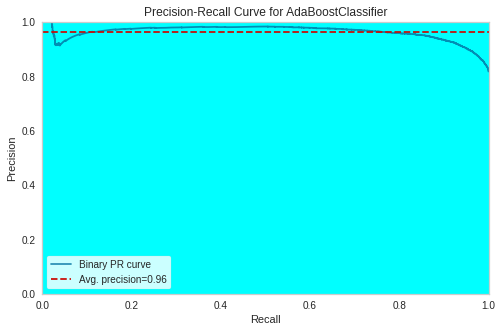

In [114]:
viz = PrecisionRecallCurve(
                            AdaBoostClassifier(n_estimators= 500, random_state = 42),
                            classes=ada.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('cyan')

viz.fit(tfidf_vectors_train,y_train)
viz.score(tfidf_vectors_test, y_test)
viz.show();

In [115]:
ada_AP_tfidf = viz.score_

In [116]:
comparison = pd.DataFrame({"Model": ["NB_bi", "LR_bi", "SVM_bi", "RF_bi", "AB_bi",
                                     "NB_tfidf", "LR_tfidf", "SVM_tfidf", "RF_tfidf", "AB_tfidf"],
                        "F1 Score": [nb_count_f1_bi, log_count_f1_bi, svc_count_f1_bi,rf_count_f1_bi, ada_count_f1_bi,
                                     nb_count_f1_tfidf, log_count_f1_tfidf, svc_count_f1_tfidf,rf_count_f1_tfidf, ada_count_f1_tfidf],
                        "Recall Score": [nb_count_rec_bi, log_count_rec_bi, svc_count_rec_bi, rf_count_rec_bi, ada_count_rec_bi,
                                         nb_count_rec_tfidf, log_count_rec_tfidf, svc_count_rec_tfidf, rf_count_rec_tfidf, ada_count_rec_tfidf],
                        "Average Precision Score": [nb_AP_bi, log_AP_bi, svc_AP_bi, rf_AP_bi,ada_AP_bi,
                                                    nb_AP_tfidf, log_AP_tfidf, svc_AP_tfidf, rf_AP_tfidf,ada_AP_tfidf]})

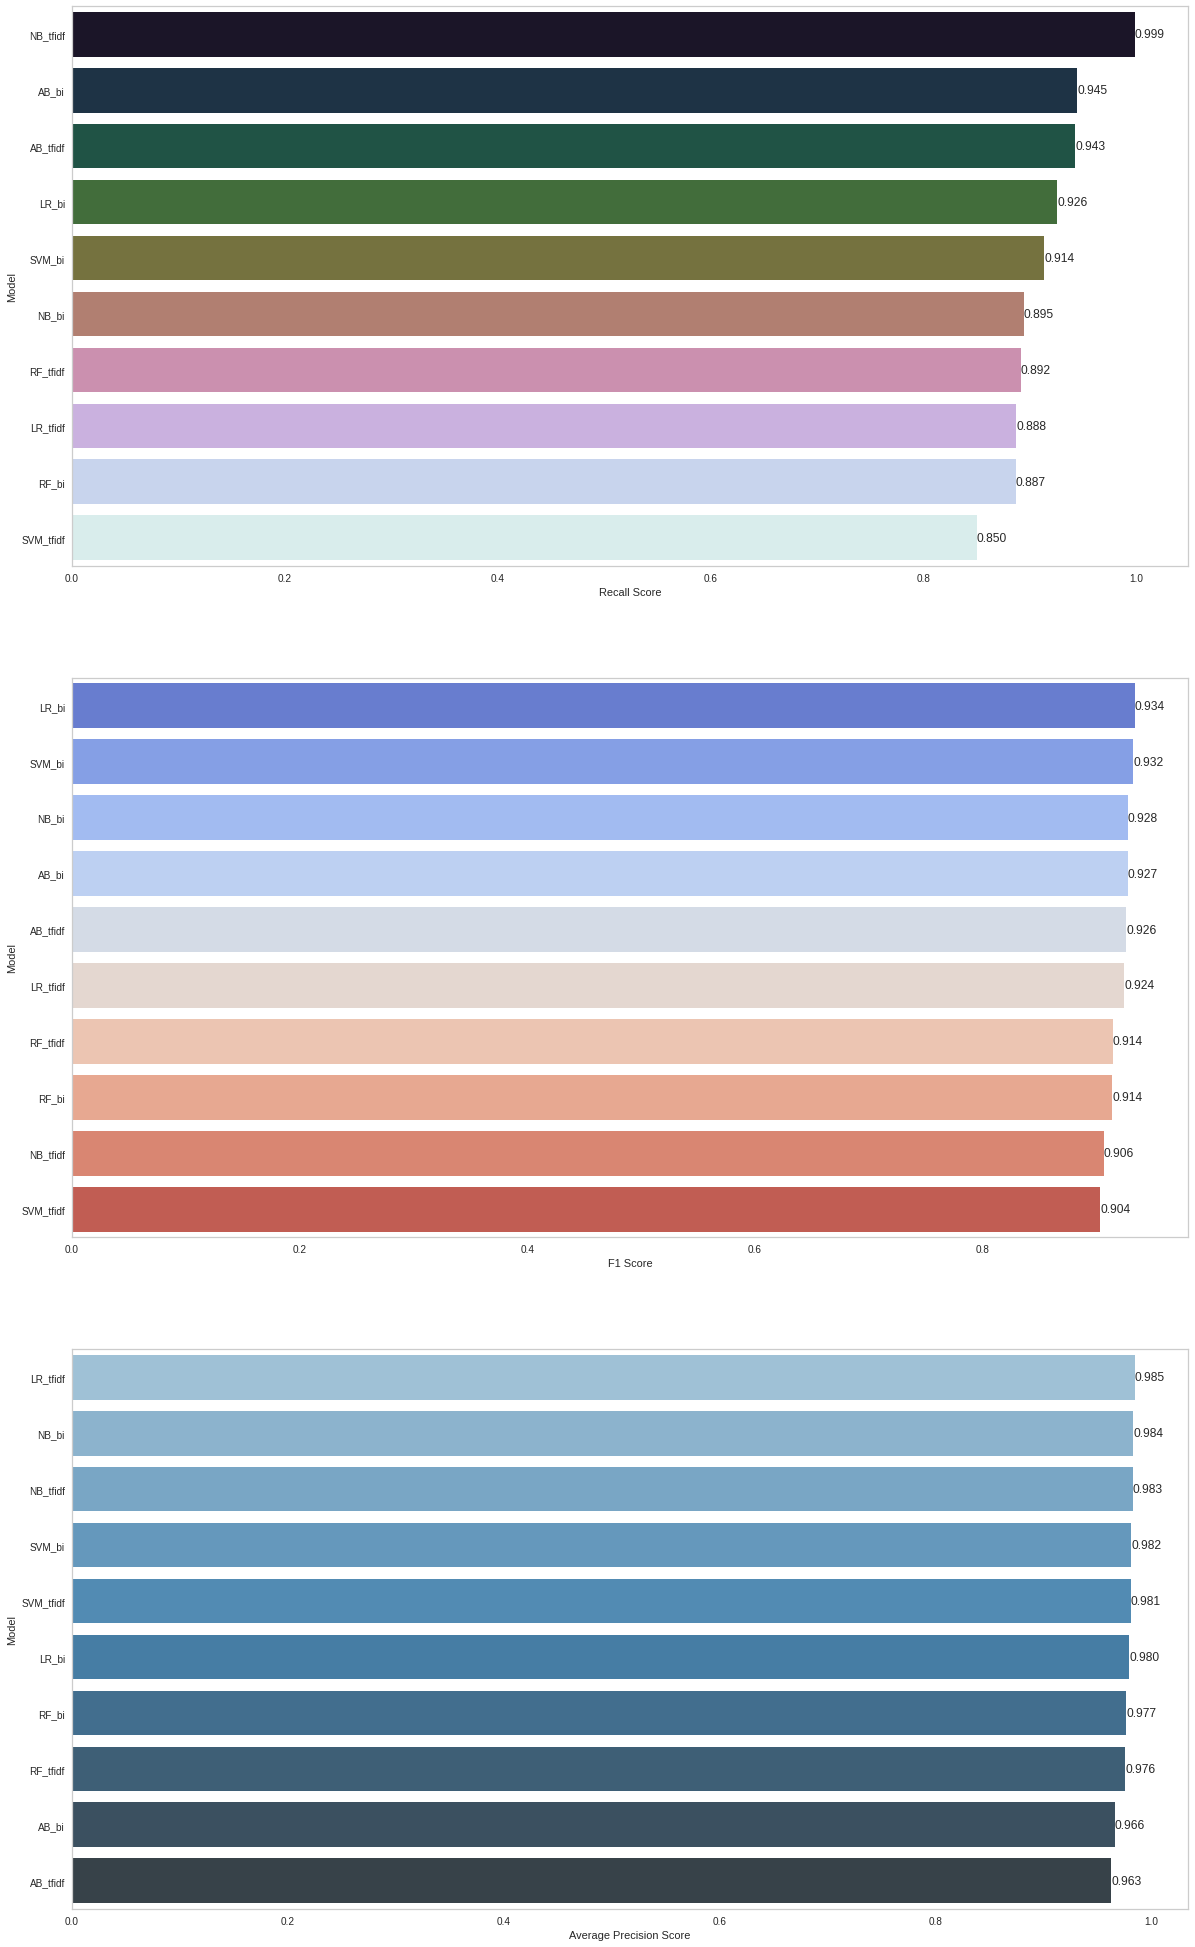

In [117]:
def labels(ax):                    
    for p in ax.patches:
        width = p.get_width()                        
        ax.text(width,                               
                p.get_y() + p.get_height() / 2,      
                '{:1.3f}'.format(width),             
                ha = 'left',                         
                va = 'center')                      
    
plt.figure(figsize=(20,35))
plt.subplot(311)
comparison = comparison.sort_values(by="Recall Score", ascending=False)
ax=sns.barplot(x="Recall Score", y="Model", data=comparison, palette="cubehelix")
ax.grid(False)
labels(ax)

plt.subplot(312)
comparison = comparison.sort_values(by="F1 Score", ascending=False)
ax=sns.barplot(x="F1 Score", y="Model", data=comparison, palette="coolwarm")
ax.grid(False)
labels(ax)

plt.subplot(313)
comparison = comparison.sort_values(by="Average Precision Score", ascending=False)
ax=sns.barplot(x="Average Precision Score", y="Model", data=comparison, palette="Blues_d")
ax.grid(False)
labels(ax)
plt.show();